### Import Required Libraries

In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

## Read IIT Data Bombay

In [2]:
# !pip install datasets==1.18.1
from datasets import load_dataset
dataset = load_dataset("cfilt/iitb-english-hindi")

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [1]:
data_size=15000

In [2]:
deu_eng=[]
for translation_pair in dataset["train"]["translation"][:15000]:
  source_sentence = translation_pair["hi"]
  target_sentence = translation_pair["en"]
  deu_eng.append([target_sentence, source_sentence ])


NameError: name 'dataset' is not defined

In [5]:
len(deu_eng)

15000

In [6]:

deu_eng = array(deu_eng)

In [7]:
del dataset

In [8]:
deu_eng



array([['Give your application an accessibility workout',
        'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'],
       ['Accerciser Accessibility Explorer',
        'एक्सेर्साइसर पहुंचनीयता अन्वेषक'],
       ['The default plugin layout for the bottom panel',
        'निचले पटल के लिए डिफोल्ट प्लग-इन खाका'],
       ...,
       ['CVS: Log file / directory', 'CVS: Log file/directory'],
       ['Choose file or directory to get log for:',
        'फ़ाइल या निर्देशिका को लॉग लेने के लिए चुनेंः'],
       ['Options', 'विकल्प']], dtype='<U398')

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [ ]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Mary has very long hair.', 'Maria hat sehr langes Haar.'],
       ["Mary is Tom's secretary.", 'Maria ist Toms Sekretärin.'],
       ['Mary is a married woman.', 'Maria ist eine verheiratete Frau.']],
      dtype='<U380')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [ ]:
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Mary has very long hair', 'Maria hat sehr langes Haar'],
       ['Mary is Toms secretary', 'Maria ist Toms Sekretärin'],
       ['Mary is a married woman', 'Maria ist eine verheiratete Frau']],
      dtype='<U380')

In [15]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [16]:
deu_eng

array([['give your application an accessibility workout',
        'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'],
       ['accerciser accessibility explorer',
        'एक्सेर्साइसर पहुंचनीयता अन्वेषक'],
       ['the default plugin layout for the bottom panel',
        'निचले पटल के लिए डिफोल्ट प्लग-इन खाका'],
       ...,
       ['cvs: log file / directory', 'cvs: log file/directory'],
       ['choose file or directory to get log for:',
        'फ़ाइल या निर्देशिका को लॉग लेने के लिए चुनेंः'],
       ['options', 'विकल्प']], dtype='<U398')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [17]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [18]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

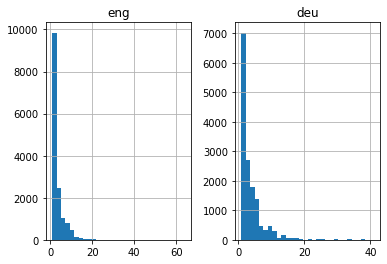

In [19]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [20]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [21]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2035


In [22]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 2504


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [23]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [25]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [26]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 70s 2ms/step - loss: 3.5693 - val_loss: 3.2825

Epoch 00001: val_loss improved from inf to 3.28246, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 69s 2ms/step - loss: 2.9459 - val_loss: 2.8888

Epoch 00002: val_loss improved from 3.28246 to 2.88876, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 70s 2ms/step - loss: 2.7409 - val_loss: 2.7025

Epoch 00003: val_loss improved from 2.88876 to 2.70251, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 69s 2ms/step - loss: 2.5648 - val_loss: 2.5602

Epoch 00004: val_loss improved from 2.70251 to 2.56023, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 69s 2ms/step - loss: 2.4135 - val_loss: 2.4447

Epoch 00005: val_loss improved from 2.56023 to 2.44467, savin

Let's compare the training loss and the validation loss.

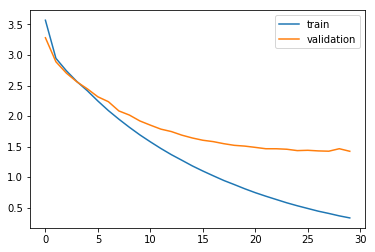

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,weve run out of gas,we have out of gas
1,its a fad,this is a
2,tom was shaken,tom was distressed
3,this annoys me,this me
4,let me do that for you,let me do you
5,you will pay for this,youll pay for this
6,tom often cuts classes,tom often to
7,hes young and healthy,he is young angry
8,life is enjoyable,life is beautiful
9,i know it sounds silly,i know it


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [ ]:
pred_df.sample(15)

,actual,predicted
4719,id like to know why,id like to know why
6533,i dont need a car,i dont need a car
8505,youve got a fever,you have a fever
6081,dont come again,dont come again
5615,im tired of boston,im am boston
868,i mean no disrespect,i dont want to be
1415,take a number,take a number
3561,what does it say,what does it
1292,shes still young,she is young
7759,youre out of order,youre not normal
